In [26]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math

from scipy import stats
import statsmodels.api as sm

#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs):
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo



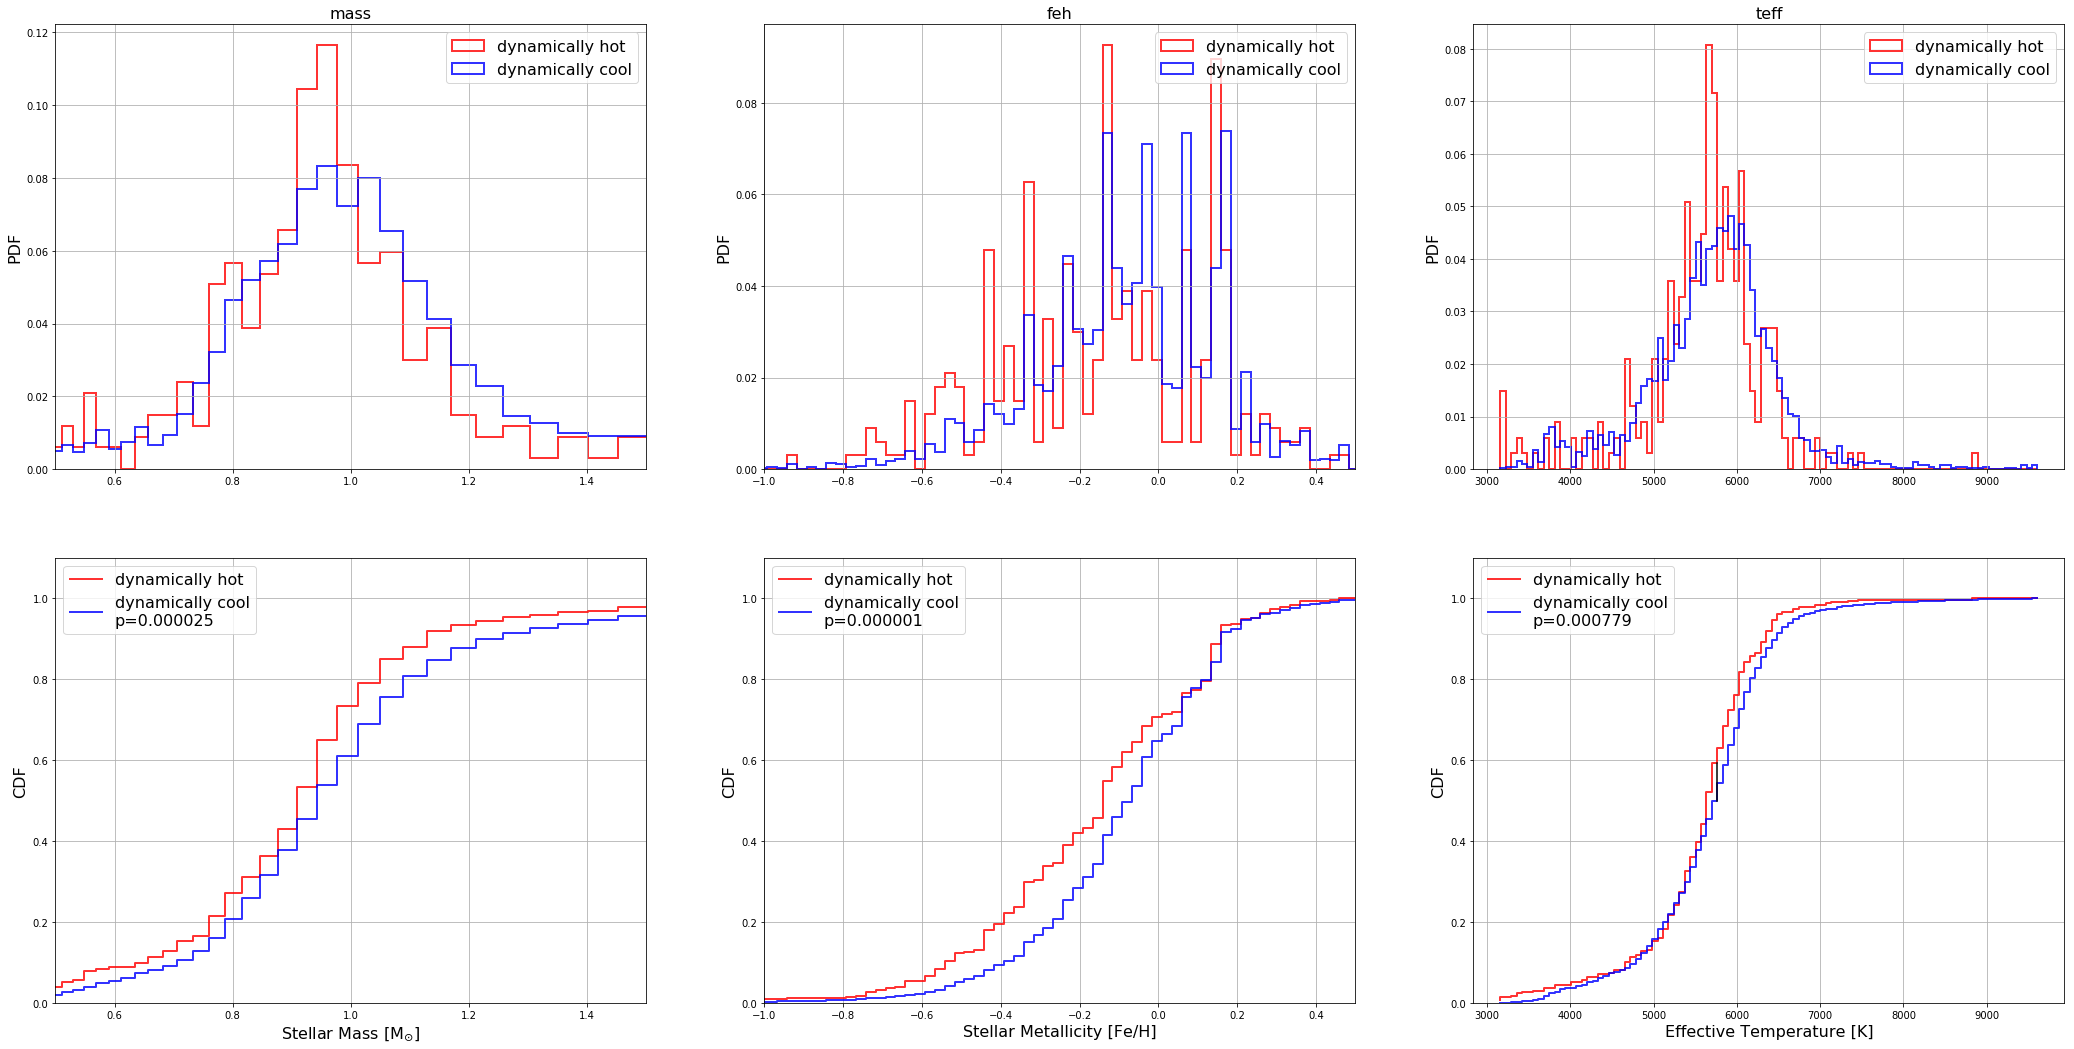

In [2]:
data1=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv')
data2=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_cool.csv')


#mass correlation
hot_mass=data1['mass']
cool_mass=data2['mass']


s1=stats.ks_2samp(hot_mass,cool_mass)
fig=plt.figure(figsize=(36,18))
ax13=plt.subplot(2,3,1)
bins=np.logspace(np.log10(min(min(hot_mass),min(cool_mass))),np.log10(max(max(hot_mass),max(cool_mass))),100)
weights1 = np.ones_like(hot_mass)/float(len(hot_mass))

ax13.hist(hot_mass,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_mass)/float(len(cool_mass))
ax13.hist(cool_mass,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')#+'\n'+'p='+'{:3e}'.format(s1[1]))
ax13.grid(True)
#plt.setp(ax13.get_xticklabels(), visible=False)
ax13.legend(loc='best',fontsize=16)
ax13.set_ylabel("PDF",fontsize=16)
#ax13.set_xscale('log')
ax13.set_xlim(0.5,1.5)

ax14=plt.subplot(2,3,4)
ecdf=sm.distributions.ECDF(hot_mass)
counts1=ecdf(bins)
ax14.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_mass)
counts2=ecdf(bins)
ax14.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax14.set_xlabel("Stellar Mass [M$_{\odot}$]",fontsize=16)
ax14.set_ylabel("CDF",fontsize=16)
ax14.set_ylim(0,1.1)
ax14.grid(True)
ax14.legend(loc='best',fontsize=16)
#ax14.set_xscale('log')
ax14.set_xlim(0.5,1.5)
#ax14.text('D = 0.1099')

#feh correlation
hot_feh=data1['feh']
cool_feh=data2['feh']

s1=stats.ks_2samp(hot_feh,cool_feh)
#fig=plt.figure(figsize=(36,18))
ax15=plt.subplot(2,3,2)
bins=np.linspace(min(min(hot_feh),min(cool_feh)),max(max(hot_feh),max(cool_feh)),100)
weights1 = np.ones_like(hot_feh)/float(len(hot_feh))

ax15.hist(hot_feh,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_feh)/float(len(cool_feh))
ax15.hist(cool_feh,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax15.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax15.legend(loc='best',fontsize=16)
ax15.set_ylabel("PDF",fontsize=16)
#ax15.set_xscale('log')
ax15.set_xlim(-1,0.5)

ax16=plt.subplot(2,3,5)
ecdf=sm.distributions.ECDF(hot_feh)
counts1=ecdf(bins)
ax16.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_feh)
counts2=ecdf(bins)
ax16.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax16.set_xlabel("Stellar Metallicity [Fe/H]",fontsize=16)
ax16.set_ylabel("CDF",fontsize=16)
ax16.set_ylim(0,1.1)
ax16.grid(True)
ax16.legend(loc='best',fontsize=16)
#ax16.set_xscale('log')
ax16.set_xlim(-1,0.5)
#ax16.text('D = 0.1099')


hot_teff=data1['teff_b2018']
cool_teff=data2['teff_b2018']

s1=stats.ks_2samp(hot_teff,cool_teff)
#fig=plt.figure(figsize=(36,18))
ax17=plt.subplot(2,3,3)
bins=np.linspace(min(min(hot_teff),min(cool_teff)),max(max(hot_teff),max(cool_teff)),100)
weights1 = np.ones_like(hot_teff)/float(len(hot_teff))

ax17.hist(hot_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_teff)/float(len(cool_teff))
ax17.hist(cool_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax17.grid(True)
#plt.setp(ax17.get_xticklabels(), visible=False)
ax17.legend(loc='best',fontsize=16)
ax17.set_ylabel("PDF",fontsize=16)
#ax17.set_xscale('log')

ax18=plt.subplot(2,3,6)
ecdf=sm.distributions.ECDF(hot_teff)
counts1=ecdf(bins)
ax18.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_teff)
counts2=ecdf(bins)
ax18.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax18.set_xlabel("Effective Temperature [K]",fontsize=16)
ax18.set_ylabel("CDF",fontsize=16)
ax18.set_ylim(0,1.1)
ax18.grid(True)
delta=[]
for i in range(0,len(bins)):
    delta.append(counts1[i]-counts2[i])
    
id_Dvalue=np.argmax(delta)
teff_dvalue=bins[id_Dvalue]
yy=np.linspace(counts2[id_Dvalue],counts1[id_Dvalue],1000)
xx=[bins[id_Dvalue]]*1000
ax18.plot(xx,yy,'k-')#,linewidth=5,label='D ='+' {:5f}'.format(s1[0])+'\n'+'P ='+' {:5f}'.format(s1[1]))
ax18.legend(loc='best',fontsize=16)
#ax12.set_xscale('log')
#ax12.text('D = 0.1099')

#ax18.annotate('D ='+' {:5f}'.format(s1[0])+'\n'+'P ='+' {:5f}'.format(s1[1]), xy=(bins[id_Dvalue], counts2[id_Dvalue]), xytext=(8000, 0.6),
#            arrowprops=dict(facecolor='black', shrink=0.05),fontsize=16)



ax13.set_title('mass',fontsize=16)
ax15.set_title('feh',fontsize=16)
ax17.set_title('teff',fontsize=16)
plt.savefig('result/2sigma_correlation.eps',dpi=300)
plt.show()

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dyz/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


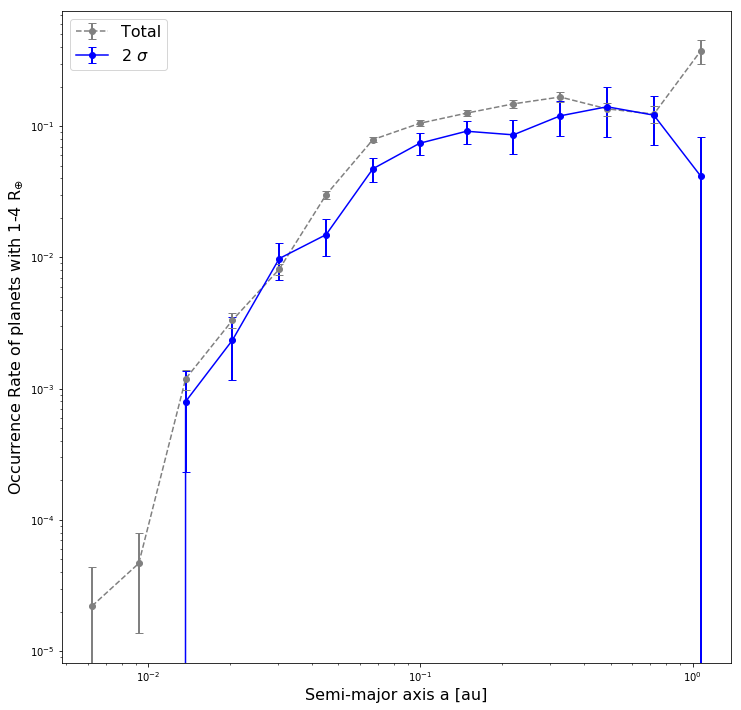

In [3]:
#change the Orbital periods to semi-major axis 

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_a=np.logspace(math.log(0.005,2),math.log(1.28,2),15,base=2)
'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tot 
'''
stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/result/occurrence_tot.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

fig=plt.figure(figsize=(12,12))
colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
#colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#fig=plt.figure(figsize=(12,12))
#for k in range(2,7):
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
   
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(0,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 \
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=400:     
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))
        
plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o--",color='grey',elinewidth=2,capsize=4,label='Total')



'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1sigma 

stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_hot.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/result/occurrence_rate_hot_2020.csv')

f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

#colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']

#for k in range(2,7):
f_p=[]
f_p_std=[]
p=[]
p_std=[]
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:       
            focc_temp.append(f_occurrence_everyplanet[j])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append(np.mean(np.mean(p_temp)))
    p_std.append(np.std(np.std(p_temp)))
        
plt.errorbar(p,f_p,yerr=f_p_std,fmt="o-",color='black',elinewidth=2,capsize=4,label='1 $\sigma$')




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1.5sigma 

stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1.5sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_hot.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1.5sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

#colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#for k in range(2,7):
f_p=[]
f_p_std=[]
p=[]
p_std=[]
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    p_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1:       
            focc_temp.append(f_occurrence_everyplanet[j])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append(np.mean(np.mean(p_temp)))
    p_std.append(np.std(np.std(p_temp)))
        
plt.errorbar(p,f_p,yerr=f_p_std,fmt="o-",color='b',elinewidth=2,capsize=4,label='1.5 $\sigma$')
'''

'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
2sigma 
'''
stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

#colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#for k in range(2,7):
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
   
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(1,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1\
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=400:      
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))

plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o-",color='b',elinewidth=2,capsize=4,label='2 $\sigma$')


#plt.errorbar(p,f_p,xerr=p_std,fmt="o:",elinewidth=2,capsize=4,label='0.25-1 R$_{\oplus}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)


plt.savefig('result/f_a_tot_2sigma_no_false.eps')

#add the error bar

[9058. 3146. 6140. ... 6548. 5430. 6753.]
[0.018921500360808828, 0.12899836101424922, 0.28229873158829843, 0.032632099248762265, 0.09931229842252667, 0.07251861563200526, 0.019481124992533915, 0.015509384743822746, 0.12837435218718873, 0.05650833718154257, 0.029907049861147252, 0.10903218069167496, 0.062372408896441064, 0.019048994750593344, 0.04243741018026802, 0.12998192683263898, 0.23416101693160515, 0.3034812381677701, 0.17663694533711374, 0.17110851282916856, 0.09212096501049423, 0.8527056589383134, 0.026536499891387844, 0.04173414523289978, 0.05623755478527229, 0.03477996836324807, 0.030209875154273095, 0.15161842100337067, 0.14917574099139672, 0.2243677834408661, 0.010362134598909509, 0.027349296402580374, 0.017640303828514437, 0.07143183902166611, 0.07118238358521, 0.03299175320168704, 0.4149394659287442, 0.02443831463160006, 0.16283248782007076, 0.07694345063111101, 0.3308111558393035, 0.35078467367678634, 0.012420594112525128, 1.3588944171192097, 0.021958389467192845, 0.10081

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


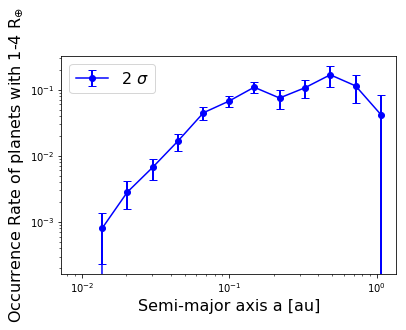

In [35]:
import random

hot_stellar=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

sequence_zero=np.linspace(0,len(hot_stellar),len(hot_stellar)+1)
sequence_new=sequence_zero
random.shuffle(sequence_new)

print(sequence_new)
a_koi=[]
for i in range(0,len(koi_table)):
    a_koi.append(a(hot_stellar['mass'][int(sequence_new[i])],koi_table['koi_period'][i])/c.au.value)

print(a_koi)
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(1,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1\
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' and koi_table['koi_period'][f_id[j]]<=400:      
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))

plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o-",color='b',elinewidth=2,capsize=4,label='2 $\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)


[9893. 8611.  226. ... 5459. 9583.  254.]
[0.018996915667106987, 0.13841448064945375, 0.2522852788784955, 0.028627386869817813, 0.09795969902688649, 0.06899758767799423, 0.020167696458990875, 0.018417305330905864, 0.1342883605248372, 0.06688456826195133, 0.02631599996654335, 0.09110493320400767, 0.05918810561477862, 0.02288138690402674, 0.034210805000478545, 0.1353862234186943, 0.22223479474980457, 0.3049209240337064, 0.15898153152280498, 0.1698532534630944, 0.09190547658605121, 0.8049519867481668, 0.023156974554015764, 0.03687190210976178, 0.04942913616311864, 0.03276573147217295, 0.02502757091028341, 0.13169831256036096, 0.13935591424780328, 0.23539764417304698, 0.01086384358164436, 0.0283424177445352, 0.019496230484950135, 0.06926502569493641, 0.07478450839815719, 0.03361519715878597, 0.5309008529680901, 0.023833423871375214, 0.1512954975002785, 0.06928795189779567, 0.36100415429870325, 0.29757483780413846, 0.012336097659227786, 1.388184169698567, 0.02160012706777411, 0.107244553893

/home/dyz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


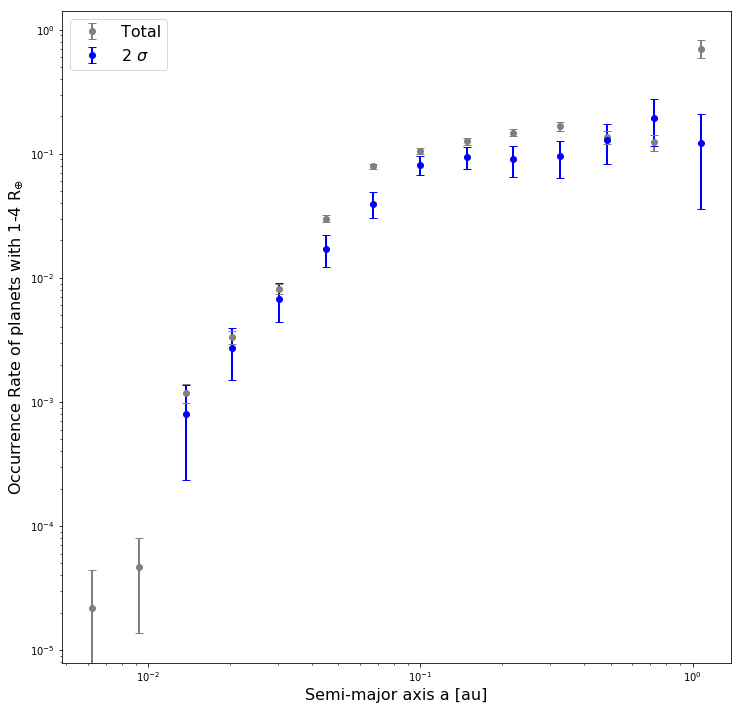

In [44]:
# get the random sequence
import random

bins_period=np.logspace(math.log(0.4,5),math.log(250,5),13,base=5)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_a=np.logspace(math.log(0.005,2),math.log(1.28,2),15,base=2)
'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tot 
'''
stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/result/occurrence_tot.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

fig=plt.figure(figsize=(12,12))
colors=['black','k','dimgray','dimgrey','grey','gray','darkgrey','darkgray','silver','lightgray','lightgrey','gainsboro']
#colors=['cornflowerblue','royalblue','b','blue','mediumblue','darkblue','navy','midnightblue','k']
#fig=plt.figure(figsize=(12,12))
#for k in range(2,7):
a_koi=[]
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value)
   
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(0,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 \
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE':# and koi_table['koi_period'][f_id[j]]<=400:     
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))
        
plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='grey',elinewidth=2,capsize=4,label='Total')



hot_stellar=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']

sequence_zero=np.linspace(0,len(hot_stellar),len(hot_stellar)+1)
sequence_new=sequence_zero
random.shuffle(sequence_new)

print(sequence_new)
a_koi=[]
for i in range(0,len(koi_table)):
    a_koi.append(a(hot_stellar['mass'][int(sequence_new[i])],koi_table['koi_period'][i])/c.au.value)

print(a_koi)
f_p=[]
f_p_std=[]
semi_a=[]
semi_a_std=[]
for i in range(1,len(bins_a)-1):
    focc_temp=[]
    a_temp=[]
    for j in range(0,len(f_occurrence_everyplanet)):
        if a_koi[f_id[j]]<bins_a[i+1] and a_koi[f_id[j]]>=bins_a[i] \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1\
        and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE': #and koi_table['koi_period'][f_id[j]]<=400:      
            focc_temp.append(f_occurrence_everyplanet[j])
            a_temp.append(a_koi[f_id[j]])
            
    f_p.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    semi_a.append((bins_a[i+1]+bins_a[i])/2)
    semi_a_std.append(np.std(a_temp))

plt.errorbar(semi_a,f_p,yerr=f_p_std,fmt="o",color='b',elinewidth=2,capsize=4,label='2 $\sigma$')    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Semi-major axis a [au]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)


plt.savefig('result/f_a_tot_2sigma_no_false_random.eps')        